## Observations and Insights 
# 1. There are outliers in Infubinol regimen measurements
# 2. The tumor volume decrease with the Capomulin regimen
# 3. There is a high correlation between average tumor volume and the mouse weight for the Capomulini regimen

In [536]:
%matplotlib notebook

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import random
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combined_data = mouse_metadata.merge(study_results, on="Mouse ID")

# Display the data table for preview
combined_data.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [4]:
# Checking the number of mice.
total_mice = len(combined_data.groupby(["Mouse ID"]))
print(f"Total number of mice: {total_mice}")

Total number of mice: 249


In [79]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
combined_groupby = combined_data.groupby(["Mouse ID", "Timepoint"])["Timepoint"].agg(['count'])
duplicates = combined_groupby.loc[combined_groupby['count'] > 1].reset_index()
duplicates.head(100)

,Mouse ID,Timepoint,count
0,g989,0,2
1,g989,5,2
2,g989,10,2
3,g989,15,2
4,g989,20,2


In [67]:
# Optional: Get all the data for the duplicate mouse ID. 
dup_mouse_id = duplicates["Mouse ID"].unique()
dup_timepoint = duplicates["Timepoint"].unique()

all_data_duplicate = combined_data.loc[combined_data["Mouse ID"].isin(dup_mouse_id) & combined_data["Timepoint"].isin(dup_timepoint)]
all_data_duplicate.head(100)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [72]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
data_cleaned = combined_data.drop_duplicates(subset=["Mouse ID", "Timepoint"], keep='first', inplace=False)
data_cleaned.head(3)

In [82]:
# Checking the number of mice in the clean DataFrame.
print(f"Number of duplicate mice: {len(duplicates)}")
print(f"Number of mice in the original DataFrame: {len(combined_data)}")
print(f"Number of mice in the cleaned DataFrame: {len(data_cleaned)}")

Number of duplicate mice: 5
Number of mice in the original DataFrame: 1893
Number of mice in the cleaned DataFrame: 1888


## Summary Statistics

In [139]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
mean_stat = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].mean()
median_stat = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].median()
var_stat = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].var()
std_stat = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].std()
sem_stat = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].sem()

# Assemble the resulting series into a single summary dataframe.
summary_df = pd.DataFrame({
    "mean": mean_stat,
    "median": median_stat,
    "var": var_stat,
    "std": std_stat,
    "sem": sem_stat
})

summary_df.head()

mean     median        var       std       sem
Drug Regimen Timepoint                                                     
Capomulin    0          45.000000  45.000000   0.000000  0.000000  0.000000
             5          44.266086  45.597064   5.030889  2.242964  0.448593
             10         43.084291  43.421014  12.344133  3.513422  0.702684
             15         42.064317  42.798160  16.878693  4.108369  0.838617
             20         40.716325  40.716428  19.035028  4.362915  0.909731

In [137]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
summary_sts = data_cleaned.groupby(["Drug Regimen", "Timepoint"])["Tumor Volume (mm3)"].agg(["mean", "median", "var", "std", "sem"])
summary_sts.head()

mean     median        var       std       sem
Drug Regimen Timepoint                                                     
Capomulin    0          45.000000  45.000000   0.000000  0.000000  0.000000
             5          44.266086  45.597064   5.030889  2.242964  0.448593
             10         43.084291  43.421014  12.344133  3.513422  0.702684
             15         42.064317  42.798160  16.878693  4.108369  0.838617
             20         40.716325  40.716428  19.035028  4.362915  0.909731

## Bar and Pie Charts

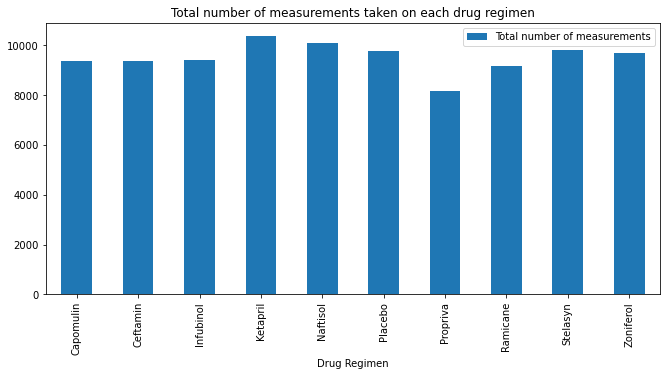

In [169]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
measurements = data_cleaned.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].sum().reset_index()
measurements = measurements.rename(columns={"Tumor Volume (mm3)":"Total number of measurements"})

title = "Total number of measurements taken on each drug regimen"
measurements.plot(kind="bar", x="Drug Regimen", y="Total number of measurements", figsize=(11,5), title=title)


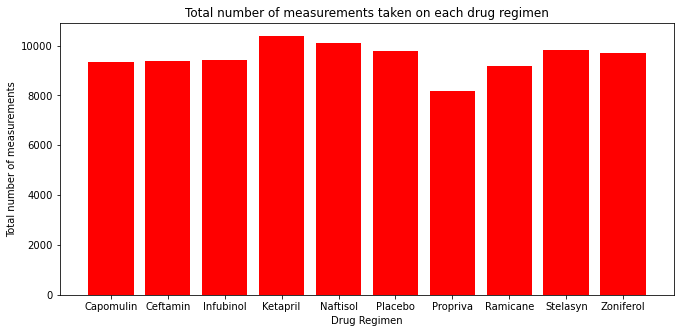

In [171]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.

plt.figure(figsize=(11, 5))
plt.title("Total number of measurements taken on each drug regimen")
plt.bar(measurements["Drug Regimen"], measurements["Total number of measurements"], color='r')
plt.xlabel("Drug Regimen")
plt.ylabel("Total number of measurements")
plt.show()

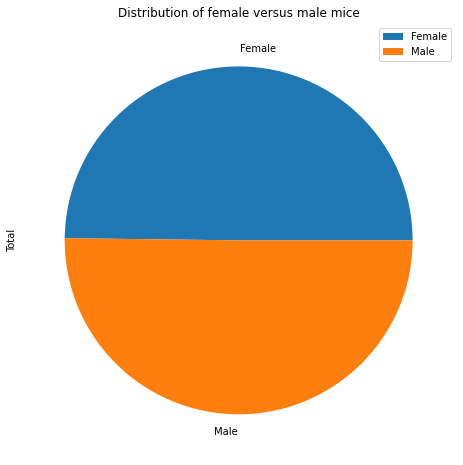

In [236]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
data_cleaned_by_id = combined_data.drop_duplicates(subset=["Mouse ID"], keep='first', inplace=False)

grouped_by_id = data_cleaned_by_id.groupby(["Sex"])["Sex"].agg(["count"])
grouped_by_id = grouped_by_id.rename(columns={"count":"Total"})

grouped_by_id.plot(kind="pie", x="Sex", y="Total", grid=True, figsize=(8,8), title="Distribution of female versus male mice")

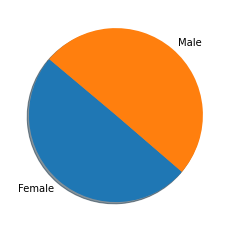

In [218]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
data_cleaned_by_id = combined_data.drop_duplicates(subset=["Mouse ID"], keep='first', inplace=False)

grouped_by_id = data_cleaned_by_id.groupby(["Sex"])["Sex"].agg(["count"])
grouped_by_id = grouped_by_id.rename(columns={"count":"Total"}).reset_index()

plt.pie(grouped_by_id["Total"].values.tolist(), labels=grouped_by_id["Sex"].values.tolist(), shadow=True, startangle=140)
plt.show()


## Quartiles, Outliers and Boxplots

In [380]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
sub_cleaned_group = data_cleaned.loc[data_cleaned["Drug Regimen"].isin(["Capomulin", "Ramicane", "Infubinol", "Ceftamin"])]
final_tumor_vol = sub_cleaned_group.groupby(["Mouse ID", "Drug Regimen"])["Tumor Volume (mm3)"].sum().reset_index()
final_tumor_vol = final_tumor_vol.rename(columns={"Tumor Volume (mm3)" : "Total Tumor Volume (mm3)"})

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint = sub_cleaned_group.drop_duplicates(subset=["Mouse ID"], keep='last', inplace=False)
last_timepoint = last_timepoint.rename(columns={"Tumor Volume (mm3)" : "Final Tumor Volume (mm3)"})

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
final_merge = last_timepoint.merge(final_tumor_vol, on=["Mouse ID", "Drug Regimen"])

final_merge.head()

# -------------------------------------------------------------------------------------------------- #

capomulin_data = data_cleaned.loc[data_cleaned["Drug Regimen"].isin(["Capomulin"])]
capomulin_final_vol = capomulin_data.drop_duplicates(subset=["Mouse ID"], keep='last', inplace=False)
capomulin_final_vol = capomulin_final_vol.rename(columns={"Tumor Volume (mm3)" : "Final Tumor Volume (mm3)"})

ramicane_data = data_cleaned.loc[data_cleaned["Drug Regimen"].isin(["Ramicane"])]
ramicane_final_vol = ramicane_data.drop_duplicates(subset=["Mouse ID"], keep='last', inplace=False)
ramicane_final_vol = ramicane_final_vol.rename(columns={"Tumor Volume (mm3)" : "Final Tumor Volume (mm3)"})

infubinol_data = data_cleaned.loc[data_cleaned["Drug Regimen"].isin(["Infubinol"])]
infubinol_final_vol = infubinol_data.drop_duplicates(subset=["Mouse ID"], keep='last', inplace=False)
infubinol_final_vol = infubinol_final_vol.rename(columns={"Tumor Volume (mm3)" : "Final Tumor Volume (mm3)"})

ceftamin_data = data_cleaned.loc[data_cleaned["Drug Regimen"].isin(["Ceftamin"])]
ceftamin_final_vol = ceftamin_data.drop_duplicates(subset=["Mouse ID"], keep='last', inplace=False)
ceftamin_final_vol = ceftamin_final_vol.rename(columns={"Tumor Volume (mm3)" : "Final Tumor Volume (mm3)"})

capomulin_final_vol.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Final Tumor Volume (mm3),Metastatic Sites
19,s185,Capomulin,Female,3,17,45,23.343598,1
29,x401,Capomulin,Female,16,15,45,28.484033,0
39,m601,Capomulin,Male,22,17,45,28.430964,1
64,f966,Capomulin,Male,16,17,20,30.485985,0
104,u364,Capomulin,Male,18,17,45,31.023923,3


In [404]:
# Put treatments into a list for for loop (and later for plot labels)
treatemnts = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
regimens_final_vol = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
capomulin_quartiles = capomulin_final_vol["Final Tumor Volume (mm3)"].quantile([.25,.5,.75])
capomulin_lowerq = capomulin_quartiles[0.25]
capomulin_upperq = capomulin_quartiles[0.75]
capomulin_iqr = capomulin_upperq - capomulin_lowerq

ramicane_quartiles = ramicane_final_vol["Final Tumor Volume (mm3)"].quantile([.25,.5,.75])
ramicane_lowerq = ramicane_quartiles[0.25]
ramicane_upperq = ramicane_quartiles[0.75]
ramicane_iqr = ramicane_upperq - ramicane_lowerq

infubinol_quartiles = infubinol_final_vol["Final Tumor Volume (mm3)"].quantile([.25,.5,.75])
infubinol_lowerq = infubinol_quartiles[0.25]
infubinol_upperq = infubinol_quartiles[0.75]
infubinol_iqr = infubinol_upperq - infubinol_lowerq

ceftamin_quartiles = ceftamin_final_vol["Final Tumor Volume (mm3)"].quantile([.25,.5,.75])
ceftamin_lowerq = ceftamin_quartiles[0.25]
ceftamin_upperq = ceftamin_quartiles[0.75]
ceftamin_iqr = ceftamin_upperq - ceftamin_lowerq

# Determine outliers using upper and lower bounds
summary_outliers = pd.DataFrame({
    "IQR": {
        "Capomulin": capomulin_iqr,
        "Ramicane": ramicane_iqr,
        "Infubinol": infubinol_iqr,
        "Ceftamin": ceftamin_iqr
    },
    "Lower Bounds": {
        "Capomulin": capomulin_lowerq - (1.5*capomulin_iqr),
        "Ramicane": ramicane_lowerq - (1.5*ramicane_iqr),
        "Infubinol": infubinol_lowerq - (1.5*infubinol_iqr),
        "Ceftamin": ceftamin_lowerq - (1.5*ceftamin_iqr)
    },
    "Upper Bounds": {
        "Capomulin": capomulin_upperq - (1.5*capomulin_iqr),
        "Ramicane": ramicane_upperq - (1.5*ramicane_iqr),
        "Infubinol": infubinol_upperq - (1.5*infubinol_iqr),
        "Ceftamin": ceftamin_upperq - (1.5*ceftamin_iqr)
    }
})

# Locate the rows which contain mice on each drug and get the tumor volumes
# add subset
regimens_final_vol.append(capomulin_final_vol["Final Tumor Volume (mm3)"].tolist())
regimens_final_vol.append(ramicane_final_vol["Final Tumor Volume (mm3)"].tolist())
regimens_final_vol.append(infubinol_final_vol["Final Tumor Volume (mm3)"].tolist())
regimens_final_vol.append(ceftamin_final_vol["Final Tumor Volume (mm3)"].tolist())


print(f"Values below Lower Bounds or above Upper Bounds could be outliers")
summary_outliers.head()

Values below Lower Bounds or above Upper Bounds could be outliers


,IQR,Lower Bounds,Upper Bounds
Capomulin,7.781863,20.704562,28.486425
Ramicane,9.098537,17.912664,27.011201
Infubinol,11.477135,36.832905,48.310040
Ceftamin,15.577752,25.355450,40.933202


<IPython.core.display.Javascript object>


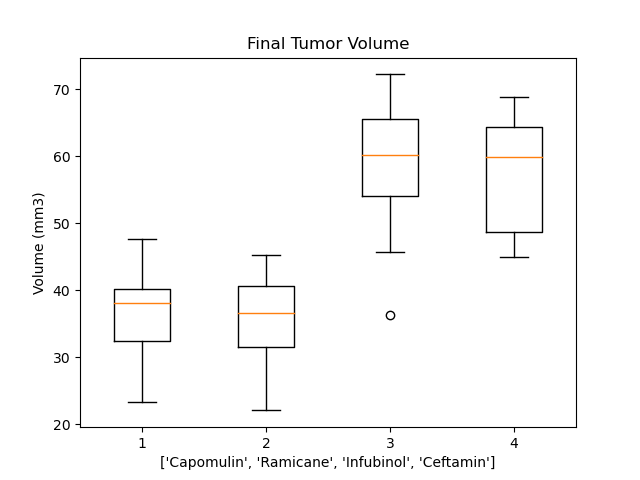

In [544]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

fig1, ax1 = plt.subplots()
ax1.set_title('Final Tumor Volume')
ax1.set_xlabel(treatemnts)
ax1.set_ylabel('Volume (mm3)')
ax1.boxplot(regimens_final_vol)
plt.show()


## Line and Scatter Plots

<IPython.core.display.Javascript object>


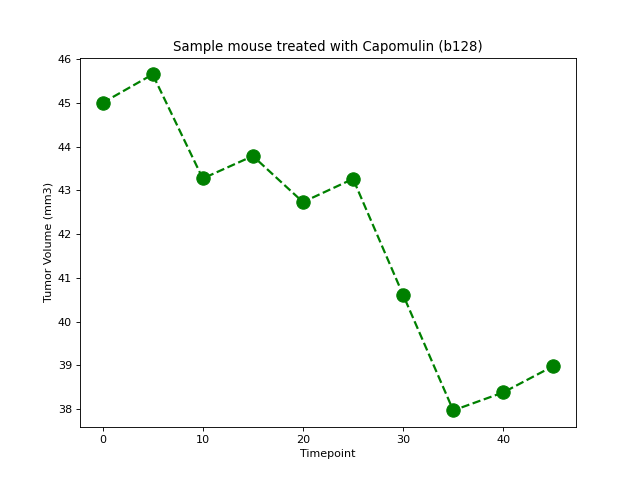

In [546]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
capomulin_id_sample = capomulin_data.sample(1).iloc[0][0]

capomulin_sample_timepoint = capomulin_data.loc[capomulin_data["Mouse ID"] == capomulin_id_sample]
capomulin_sample_timepoint.head(10)

indexes = range(len(capomulin_sample_timepoint))

y_axis = capomulin_sample_timepoint["Tumor Volume (mm3)"]
x_axis = capomulin_sample_timepoint["Timepoint"]

plt.figure(figsize=(8, 6), dpi=80)
plt.title(f"Sample mouse treated with Capomulin ({capomulin_id_sample})")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.plot(x_axis, y_axis, 'go--', linewidth=2, markersize=12)
plt.show()


<IPython.core.display.Javascript object>


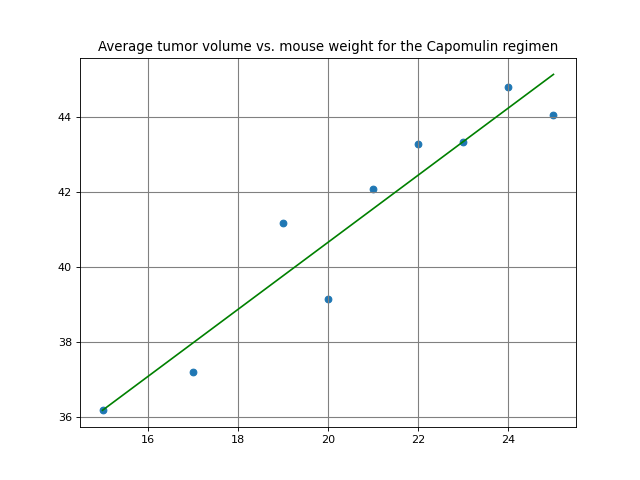

In [547]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

capomulin_weight = capomulin_data.groupby(["Weight (g)"])["Tumor Volume (mm3)"].mean().reset_index()
capomulin_weight = capomulin_weight.rename(columns={"Tumor Volume (mm3)":"Average Tumor Volume (mm3)"})

capomulin_weight = capomulin_weight.sort_values(by="Weight (g)", ascending=True)

x_values = capomulin_weight["Weight (g)"]
y_values = capomulin_weight["Average Tumor Volume (mm3)"]

plt.figure(figsize=(8, 6), dpi=80)
plt.title("Average tumor volume vs. mouse weight for the Capomulin regimen")
plt.scatter(x_values, y_values)
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.show()


## Correlation and Regression

In [548]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

correlation = st.pearsonr(x_values, y_values)
print(f"The correlation coefficient between mouse weight and average tumor volume is {round(correlation[0], 2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

plt.plot(x_values,regress_values,"g-")
plt.show()


The correlation coefficient between mouse weight and average tumor volume is 0.95
